# Project 1 - Multigrid 

In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
import numpy.linalg as la


from numba import jit

import time

%matplotlib notebook

In [2]:
@jit
def linearize(x,y,m):
    return x+y*(m-2)

In [3]:
@jit
def delinearize(k,m):
    x = k%(m-2)
    y = k//(m-2)
    return (x,y)

In [4]:
@jit
def solve_triangular(A,x,b):
    sizeF = int(np.size(A,axis=0));
    for k in range(sizeF):
            x[k] = (b[k] - np.dot(A[k,0:k], x[0:k]) -np.dot(A[k,k+1:], x[k+1:]) ) / A[k,k];
    return x

In [5]:
@jit
def create_system(m, verbose = False):
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    h_x = 1./(m-1)
    h_y = 1./(m-1)
    
    n_x = len(x)-2
    n_y = len(y)-2
    n = (n_x)*(n_y)
    A = sps.lil_matrix((n,n))
    b = np.zeros(n)
    for i in range(n_x):
        for j in range(n_y):
            index = linearize(i,j,m)
            if i==0 or i == n_x-1 or j == 0 or j == n_y -1:
                if i!= 0:
                    A[index, linearize(i-1,j,m)] = 1./(h_x**2) 
                if i != n_x-1:
                    A[index, linearize(i+1,j,m)] = 1./(h_x**2) 
                if j != 0:
                    A[index, linearize(i,j-1,m)] = 1./(h_y**2)
                if j != n_y-1:
                    A[index, linearize(i,j+1,m)] = 1./(h_x**2)
                A[index, linearize(i,j,m)] = -2 * (1./(h_x**2) + 1./(h_y**2))
            else:
                A[index, linearize(i-1,j,m)] = 1./(h_x**2)
                A[index, linearize(i+1,j,m)] = 1./(h_x**2)

                A[index, linearize(i,j,m)] = -2 * (1./(h_x**2) + 1./(h_y**2))

                A[index, linearize(i,j-1,m)] = 1./(h_y**2)
                A[index, linearize(i,j+1,m)] = 1./(h_x**2)

            b[index] =- 2 * ((1-6*x[i+1]**2)  
                             *y[j+1]**2 
                            *(1-y[j+1]**2) 
                            +(1-6*y[j+1]**2)
                            *x[i+1]**2 
                            *(1 - x[i+1]**2))

            
    if verbose:
        return A,b,x,y
    return A,b

In [6]:
@jit
def create_solution(m):
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    
    n_x = len(x)-2
    n_y = len(y)-2
    u= np.zeros((n_x,n_y))
    for i,x_i in enumerate(x[1:-1]): 
        for j,y_j in enumerate(y[1:-1]):
            u[i,j] = (x_i**2-x_i**4)*(y_j**4-y_j**2)
    return u

In [7]:
def gauss_seidel(A,b,x,atol=1e-5, plot=False, iter_start = 0):             
    if plot:
        fig,ax = plt.subplots(1,1)
        shape = int(np.sqrt(x.shape[0]))
        shape = (shape,shape)
                 
    iterations = iter_start
    
    r = b - A.dot(x)

    
    
    L = sps.tril(A)
    
    U = A - L
    while np.linalg.norm(r) > atol: 
        
        
        x = solve_triangular(L, x , b - U.dot(x))
        
        r = b - A.dot(x)
        
        iterations+=1
        
        if plot:
            x_show = x.reshape(shape)
            ax.set_title("Iteration: {}".format(iterations))
            ax.imshow(x_show)
            fig.canvas.draw()
                
    return x,iterations

In [15]:
tol = 1e-3
m = 5
A,b = create_system(m)
u = create_solution(m)

In [16]:
A.todense()

matrix([[-64.,  16.,   0.,  16.,   0.,   0.,   0.,   0.,   0.],
        [ 16., -64.,  16.,   0.,  16.,   0.,   0.,   0.,   0.],
        [  0.,  16., -64.,   0.,   0.,  16.,   0.,   0.,   0.],
        [ 16.,   0.,   0., -64.,  16.,   0.,  16.,   0.,   0.],
        [  0.,  16.,   0.,  16., -64.,  16.,   0.,  16.,   0.],
        [  0.,   0.,  16.,   0.,  16., -64.,   0.,   0.,  16.],
        [  0.,   0.,   0.,  16.,   0.,   0., -64.,  16.,   0.],
        [  0.,   0.,   0.,   0.,  16.,   0.,  16., -64.,  16.],
        [  0.,   0.,   0.,   0.,   0.,  16.,   0.,  16., -64.]])

In [31]:
# np.random.seed(0)
# x_0 = np.random.rand(b.shape[0])
# v,iters = gauss_seidel(A,b,x_0,atol=tol, plot=False)

TypeError: 'coo_matrix' object has no attribute '__getitem__'

In [ ]:
v = v.reshape(u.shape)

In [ ]:
iters

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(u)
ax1.set_title("Exact ($u$)")
ax2.imshow(v)
ax2.set_title("Approximated ($v$)")

In [128]:
def vcycle(A,b,m = None, v1=5, v2 = 5, plot=False, ax = None, fig = None):
    if not m:
        m = int(np.sqrt(b.shape[0])) + 2
        
    if plot and not ax and not fig:
        fig,ax = plt.subplots(1,1)
    shape = (m-2,m-2)
        

    
    # perform one v-cycle on the matrix A
    sizeF = int(A.shape[0]);
    # size for direct inversion < 15
    if sizeF < 15:
        x = la.solve(A,b)
        return x
    
    L = np.tril(A)
    U = A - L
    
    # v1=number of Gauss-Seidel iterations before coarsening
    x = np.zeros(sizeF);
    for numGS in range(v1):
        x = spl.solve_triangular(L,b - np.dot(U,x), lower=True)
                
        if plot:
            x_show = x[:shape[0]**2].reshape(shape)
            ax.imshow(x_show)
            fig.canvas.draw()

    # construct interpolation operator from next coarser to this mesh
    # next coarser has ((n-1)/2 + 1 ) points
    assert(sizeF%2 ==1)
    sizeC = int((sizeF-1)/2 +1)
    P = np.zeros((sizeF,sizeC));
    for k in range(sizeC):
        #x,y = delinearize(k,m)
        P[2*k,k] = 1; # copy these points
    for k in range(sizeC-1):    
        P[2*k+1,k] = .5; # average these points
        P[2*k+1,k+1] = .5;
    
    # compute residual
    residual = b - np.dot(A,x)

    # project residual onto coarser mesh
    residC = np.dot(P.transpose(),residual)
    print(residC.shape)
    # Find coarser matrix (sizeC X sizeC)
    AC = np.dot(P.transpose(),np.dot(A,P))
    vC = vcycle(AC,residC, ax=ax, fig=fig,plot=plot);
    # extend to this mesh
    x = np.dot(P,vC)
    # v2=number of Gauss-Seidel iterations after coarsening
    for numGS in range(v2):
        x = spl.solve_triangular(L,b - np.dot(U,x), lower=True)
        
    return x

<IPython.core.display.Javascript object>


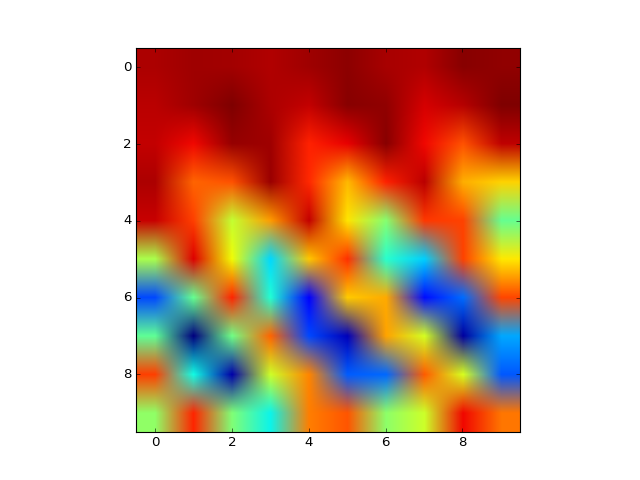

(421,)
(211,)
(106,)


AssertionError: 

In [129]:
v = vcycle(A,b,v1=10,v2=10, plot=True)
v = v.reshape(u.shape)

<IPython.core.display.Javascript object>


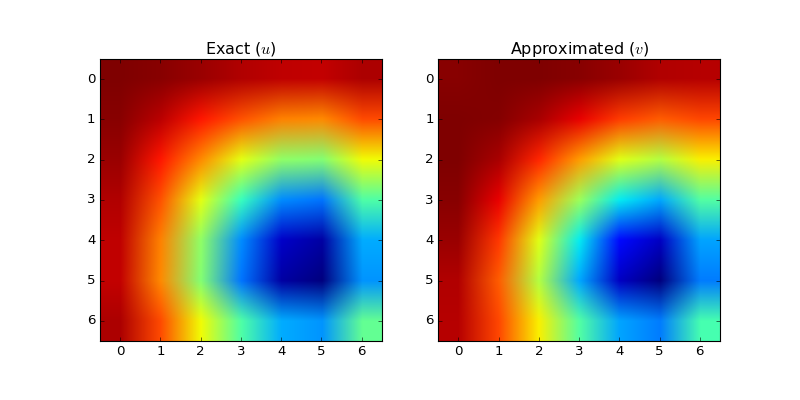

In [89]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(u)
ax1.set_title("Exact ($u$)")
ax2.imshow(v)
ax2.set_title("Approximated ($v$)")

<IPython.core.display.Javascript object>


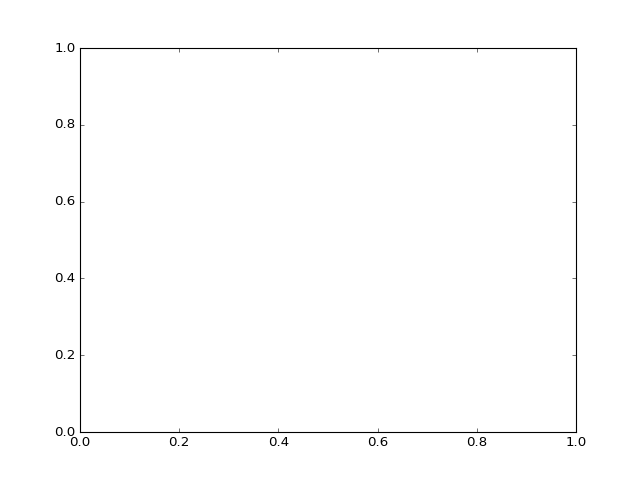

matplotlib.figure.Figure

In [108]:
fig,ax = plt.subplots(1,1)
type(fig)

In [14]:
B = np.tril(A)

TypeError: tri() takes at least 1 argument (2 given)